# Spam vs Ham Detection on SMS data

In [1]:
import nltk

### Getting the Data

Using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

In [44]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]
print(len(messages))

5574


In [3]:
for message_no, message in enumerate(messages[:5]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though


Due to the spacing we can tell that this is a Tab Separated Values file.

In [4]:
import pandas as pd

In [5]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
print(messages.duplicated().sum())
messages[messages.duplicated()][:5]

403


,label,message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls


In [8]:
messages.drop_duplicates(inplace=True)

In [9]:
print(messages.duplicated().sum())

0


In [10]:
messages.isnull().sum()

label      0
message    0
dtype: int64

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
label      5169 non-null object
message    5169 non-null object
dtypes: object(2)
memory usage: 121.1+ KB


In [12]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4516   4516  I will send them to your email. Do you mind  &...    1
spam      653    653  Congrats 2 mobile 3G Videophones R yours. call...    1

In [13]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Data Visualization

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

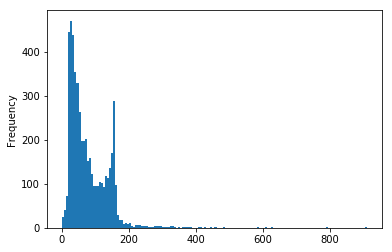

In [15]:
messages['length'].plot(bins=150, kind='hist') 

There is some really long message!

In [16]:
messages['length'].describe()

count    5169.000000
mean       79.344554
std        58.437457
min         2.000000
25%        36.000000
50%        61.000000
75%       119.000000
max       910.000000
Name: length, dtype: float64

910 characters! Using masking to find this message:

In [17]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Trying to see if message length is a distinguishing feature between ham and spam:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E76DC32780>,
      dtype=object)

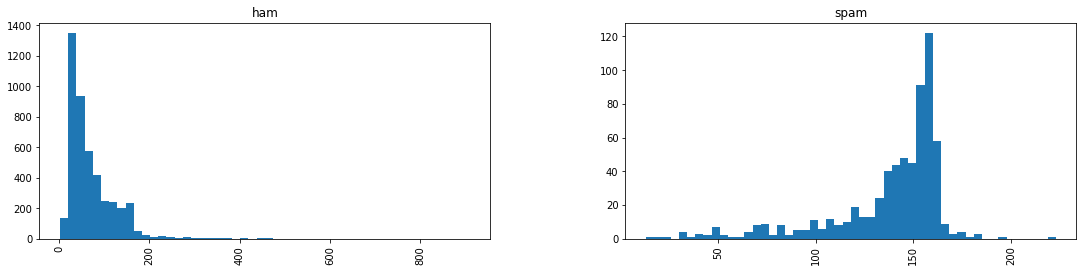

In [18]:
messages.hist(column='length', by='label', bins=50,figsize=(18,4))

Very interesting! Through just basic EDA discovered a trend that spam messages tend to have more characters. 

### Text Pre-processing

Data is all text. Classification algorithms need some sort of numerical feature vector to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach.

In [19]:
import string
from nltk.corpus import stopwords  

In [20]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
print(len(stopwords.words('english')))
l=stopwords.words('english')

179


There are 179 stopwords

In [22]:
l[:5]

['i', 'me', 'my', 'myself', 'we']

In [23]:
def text_process(mess):
    """
    Takes in a string of text, then:
    1. Removes all punctuations
    2. Removes all stopwords
    3. Returns a list of the cleaned text
    """
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in l]

In [24]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Tokenizing these messages. Tokenization is converting the text strings to a list of tokens (words that we actually want).

In [25]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools. Sometimes they don't work well for text-messages due abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'

versus

    'No dog, I don't know! What time are you heading to the club?'
    
More advanced methods:  [NLTK book online](http://www.nltk.org/book/).

### Vectorization

Converting each message, represented as a list of tokens([lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)), into a vector that machine learning models can understand.

Using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector will have as many dimensions as there are unique words in the corpus.
SciKit Learn's **CountVectorizer** converts a collection of text documents to a matrix of token counts.

This is a 2-Dimensional matrix. Where one dimension is the entire vocabulary(1 row per word) and other dimension are the actual documents(column per text message). 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, expecting a lot of zero counts for the presence of that word in that document. SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
cv = CountVectorizer(analyzer=text_process).fit(messages['message'])
print(len(cv.vocabulary_))

11425


Taking one text message and geting its bag-of-words counts as a vector.

In [28]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


It's vector representation:

In [29]:
bow4 = cv.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


This means that there are 7 unique words in that message(after removing common stop words). 2 appear twice, rest once.

In [30]:
print('2 words that appear twice:')
print(cv.get_feature_names()[4068])
print(cv.get_feature_names()[9554])

2 words that appear twice:
U
say


Using **.transform** on our Bag-of-Words (bow) transformed object to transform the entire DataFrame. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [31]:
bow = cv.transform(messages['message'])

In [32]:
print('Shape of Sparse Matrix: ', bow.shape)
print('Amount of Non-Zero occurences: ', bow.nnz)

Shape of Sparse Matrix:  (5169, 11425)
Amount of Non-Zero occurences:  46193


In [33]:
sparsity = (100.0 * bow.nnz / (bow.shape[0] * bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07821921038271838


In [34]:
bow

<5169x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 46193 stored elements in Compressed Sparse Row format>

### Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can use any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [35]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(bow, messages['label'])

Let's try classifying our single random message and checking how we do:

In [36]:
print('predicted:', nb.predict(bow4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

### Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [37]:
predictions = nb.predict(bow)
print(predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification).

In [38]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(messages['label'], predictions))
print('\n')
print (classification_report(messages['label'], predictions))

[[4501   15]
 [  14  639]]


             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      4516
       spam       0.98      0.98      0.98       653

avg / total       0.99      0.99      0.99      5169



In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data as representative of true predictive performance.

## Train Test Split

In [39]:
from sklearn.model_selection import train_test_split

msg_train,msg_test,label_train,label_test=train_test_split(messages['message'], messages['label'], test_size=0.2)

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. 

In [40]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  
    ('classifier', MultinomialNB()),   
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [41]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001E76CCF4378>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [42]:
predictions = pipeline.predict(msg_test)

In [43]:
print(confusion_matrix(predictions,label_test))
print('\n')
print(classification_report(predictions,label_test))

[[902  12]
 [  5 115]]


             precision    recall  f1-score   support

        ham       0.99      0.99      0.99       914
       spam       0.91      0.96      0.93       120

avg / total       0.98      0.98      0.98      1034



Now we have a classification report for our model on a true testing set! 